In [1]:
import django, sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *

run_id = 758

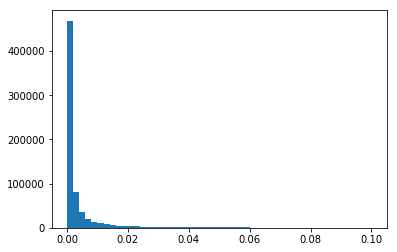

702626

In [2]:
tts = TopicTerm.objects.filter(run_id=run_id)
scores = list(tts.values_list('score',flat=True))

plt.hist([s for s in scores if s < 0.1],bins=50)

plt.show()

tts.count()

In [8]:
column = 'term_id'
column = 'doc_id'

stat = RunStats.objects.get(pk=run_id)

if column=='doc_id':
    db_matrix = DocTopic.objects.filter(run_id=run_id,score__gt=0.01)
else:
    if stat.method=="DT":
        db_matrix = DynamicTopicTerm.objects.filter(run_id=run_id,score__gt=0.001)
    else:
        db_matrix = TopicTerm.objects.filter(run_id=run_id,score__gt=0.001)


from scipy.sparse import *

vs = list(db_matrix.values('score',column,'topic_id'))

c_ind = np.array(db_matrix.values_list(column,flat=True).order_by(column).distinct())
r_ind = np.array(db_matrix.values_list('topic_id',flat=True).order_by('topic_id').distinct())

d = [x['score'] for x in vs]


c = [int(np.where(c_ind==x[column])[0]) for x in vs]
r = [int(np.where(r_ind==x['topic_id'])[0]) for x in vs]

m = csr_matrix((d,(r,c)),shape=(len(r_ind),len(c_ind)))

m = csr_matrix((d,(c,r)),shape=(len(c_ind),len(r_ind)))

print(db_matrix.count())

873366


In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=50000)
tsne_results = tsne.fit_transform(m.toarray())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 277915 samples in 495.819s...
[t-SNE] Computed neighbors for 277915 samples in 16159.979s...
[t-SNE] Computed conditional probabilities for sample 1000 / 277915
[t-SNE] Computed conditional probabilities for sample 2000 / 277915
[t-SNE] Computed conditional probabilities for sample 3000 / 277915
[t-SNE] Computed conditional probabilities for sample 4000 / 277915
[t-SNE] Computed conditional probabilities for sample 5000 / 277915
[t-SNE] Computed conditional probabilities for sample 6000 / 277915
[t-SNE] Computed conditional probabilities for sample 7000 / 277915
[t-SNE] Computed conditional probabilities for sample 8000 / 277915
[t-SNE] Computed conditional probabilities for sample 9000 / 277915
[t-SNE] Computed conditional probabilities for sample 10000 / 277915
[t-SNE] Computed conditional probabilities for sample 11000 / 277915
[t-SNE] Computed conditional probabilities for sample 12000 / 277915
[t-SNE] Computed conditional 

In [ ]:
plt.rcParams["figure.figsize"] = [7.2,4.5]
plt.rcParams["figure.figsize"] = [14.4,9]

cmap = {
    1: "#66c2a5",
    2: "#fc8d62",
    3: "#8da0cb"
}

cs = []
sizes = []
xs = []
ys = []

for i,d in enumerate(Doc.objects.filter(id__in=r_ind)):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    #if x > -7 and x < -5 and y > 4 and y < 6:
    if d.wosarticle.tc > 10:
        plt.text(x,y,t.title,fontsize=7)
        #cs.append(cmap[t.primary_wg])
        sizes.append(ts.wosarticle.tc)
        xs.append(x)
        ys.append(y)

plt.scatter(
    xs,
    ys,
    #s=sizes,
    #c=cs,
)
plt.show()

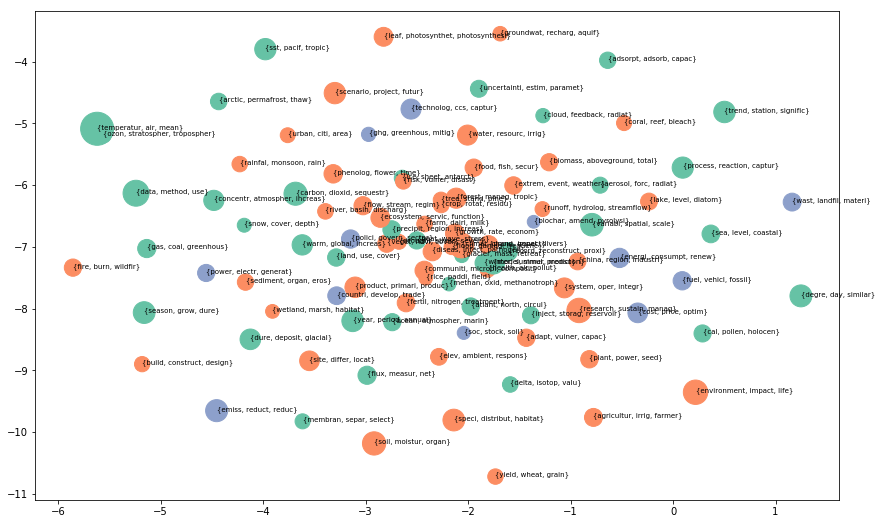

In [7]:
plt.rcParams["figure.figsize"] = [7.2,4.5]
plt.rcParams["figure.figsize"] = [14.4,9]

cmap = {
    1: "#66c2a5",
    2: "#fc8d62",
    3: "#8da0cb"
}

cs = []
sizes = []
xs = []
ys = []

for i,t in enumerate(Topic.objects.filter(id__in=r_ind)):
    x = tsne_results[i,0]
    y = tsne_results[i,1]
    #if x > -7 and x < -5 and y > 4 and y < 6:
    if x>-10:
        plt.text(x,y,t.title,fontsize=7)
        cs.append(cmap[t.primary_wg])
        sizes.append(t.score)
        xs.append(x)
        ys.append(y)

plt.scatter(
    xs,
    ys,
    s=sizes,
    c=cs,
)
plt.show()

In [6]:
r_ind

array([124964, 124965, 124966, 124967, 124968, 124969, 124970, 124971,
       124972, 124973, 124974, 124975, 124976, 124977, 124978, 124979,
       124980, 124981, 124982, 124983, 124984, 124985, 124986, 124987,
       124988, 124989, 124990, 124991, 124992, 124993, 124994, 124995,
       124996, 124997, 124998, 124999, 125000, 125001, 125002, 125003,
       125004, 125005, 125006, 125007, 125008, 125009, 125010, 125011,
       125012, 125013, 125014, 125015, 125016, 125017, 125018, 125019,
       125020, 125021, 125022, 125023, 125024, 125025, 125026, 125027,
       125028, 125029, 125030, 125031, 125032, 125033, 125034, 125035,
       125036, 125037, 125038, 125039, 125040, 125041, 125042, 125043,
       125044, 125045, 125046, 125047, 125048, 125049, 125050, 125051,
       125052, 125053, 125054, 125055, 125056, 125057, 125058, 125059,
       125060, 125061, 125062, 125063])